# What we are trying to do here

- Performing the same analysis I did with just-eat data but from Zomato.co.uk data
- Add new information with  calculated fields (Area cover b restaurant, cluster belonging)



In [1]:
import requests
from bs4 import BeautifulSoup
import urllib2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sqlalchemy.engine import create_engine

In [2]:
#In two separate notebook, I explained how to get restaurant information from Zomato API
#I stored those information into my local database
# I am now performing the EDA on it

engine=create_engine('postgresql://localhost:5432/capstone')
conn=engine.connect()
df_zomato=pd.read_sql("zoomato_1",conn)
del df_zomato["index"]
df_zomato.head()

,id,name,cuisines,price_range,average_cost_for_two,aggregate_rating,votes,city,locality,zipcode,latitude,longitude
0,6111707,Barracuda,Drinks Only,2.0,25.0,2.6,7,London,Ealing,W5 2PJ,51.514176,-0.300338
1,6102909,Starbucks,Cafe,1.0,15.0,3.1,4,London,Ealing,W5 5DA,51.511031,-0.305182
2,6124523,The Ashbourne,"British, Pizza",3.0,40.0,0.0,0,London,Ealing,W5 3QU,51.529258,-0.291637
3,6125893,Ristorante Belvedere,Italian,3.0,50.0,0.0,1,London,Ealing,W5 1EE,51.530182,-0.292677
4,6125648,Royal Nawaab,"Indian, Curry",3.0,50.0,3.5,19,London,Greenford,UB6 8DW,51.533616,-0.318741


In [3]:
# As we did with just eat data, let's try to group cuisines by main type of cuisine
# how many cuisine display per restaurant?
cuisine={}
max_cuisine=[]
for cuis in df_zomato["cuisines"]:
    listy=cuis.split(",")
    max_cuisine.append(len(listy))
    for item in listy:
        if item not in cuisine.keys():
            cuisine[item]=1
        else:
            cuisine[item]=cuisine[item]+1

print "Number of cuisine types/qualifications per restaurant (Max, Min, Average):\n", (max(max_cuisine),min(max_cuisine),round(np.mean(max_cuisine),0))
print "Total number of cuisine types/qualifications:\n", len(cuisine.keys())
print "Some cuisine types:\n",cuisine.keys()[:10]

Number of cuisine types/qualifications per restaurant (Max, Min, Average):
(8, 1, 2.0)
Total number of cuisine types/qualifications:
165
Some cuisine types:
[u'', u'Continental', u' Austrian', u'Arabian', u'European', u'Polish', u' Healthy Food', u'Juices', u'French', u'Street Food']


In [4]:
# As the average is 2, types of cuisines, we will split the cuisine group in 3 columns
# I assume the first column represent the principal cuisine, the one I will try to regroup

def split_cuisine(row,position):
    listy=row.split(",")
    result=""
    if position <= len(listy)-1:
        result=listy[position]
    else:
        result=""
    return result

df_zomato["Cuisine_1"]=df_zomato["cuisines"].apply(lambda x: split_cuisine(x,0))
df_zomato["Cuisine_2"]=df_zomato["cuisines"].apply(lambda x: split_cuisine(x,1))
df_zomato["Cuisine_3"]=df_zomato["cuisines"].apply(lambda x: split_cuisine(x,2))

df_zomato.head()

,id,name,cuisines,price_range,average_cost_for_two,aggregate_rating,votes,city,locality,zipcode,latitude,longitude,Cuisine_1,Cuisine_2,Cuisine_3
0,6111707,Barracuda,Drinks Only,2.0,25.0,2.6,7,London,Ealing,W5 2PJ,51.514176,-0.300338,Drinks Only,,
1,6102909,Starbucks,Cafe,1.0,15.0,3.1,4,London,Ealing,W5 5DA,51.511031,-0.305182,Cafe,,
2,6124523,The Ashbourne,"British, Pizza",3.0,40.0,0.0,0,London,Ealing,W5 3QU,51.529258,-0.291637,British,Pizza,
3,6125893,Ristorante Belvedere,Italian,3.0,50.0,0.0,1,London,Ealing,W5 1EE,51.530182,-0.292677,Italian,,
4,6125648,Royal Nawaab,"Indian, Curry",3.0,50.0,3.5,19,London,Greenford,UB6 8DW,51.533616,-0.318741,Indian,Curry,


In [5]:
# how is the hierarchy?
pivot1=pd.pivot_table(df_zomato,index=["Cuisine_1","Cuisine_2","Cuisine_3"],values=["Ranking"],aggfunc=np.count_nonzero)
pivot1[:20]

Cuisine_1  Cuisine_2   Cuisine_3 
                                      0
Afghani                               3
            Curry       Fast Food     3
            Persian                   2
                        Turkish       3
African                               4
            Arabian     Asian         3
            Nigerian                 18
            Somali                    2
            Zambian                   2
American                              5
            British                   2
            Burger                   10
                        Thai          3
            Fast Food                 4
            Grill                     2
            Italian     Burger       15
            Steak                     2
Arabian                               1
Asian                                 1
dtype: int64

In [6]:
cuisine_1=df_zomato["Cuisine_1"].unique()
print "Main Cuisine number",len(cuisine_1)
cuisine_2=df_zomato["Cuisine_2"].unique()
print "Second Cuisine number",len(cuisine_2)
cuisine_3=df_zomato["Cuisine_3"].unique()
print "Third Cuisine number",len(cuisine_3)

Main Cuisine number 78
Second Cuisine number 78
Third Cuisine number 57


Although, we do not have a clear decrease of number of cuisine between cuisine 1,2 and 3 as we had with just-eat, I am just focusing on cuisine_1


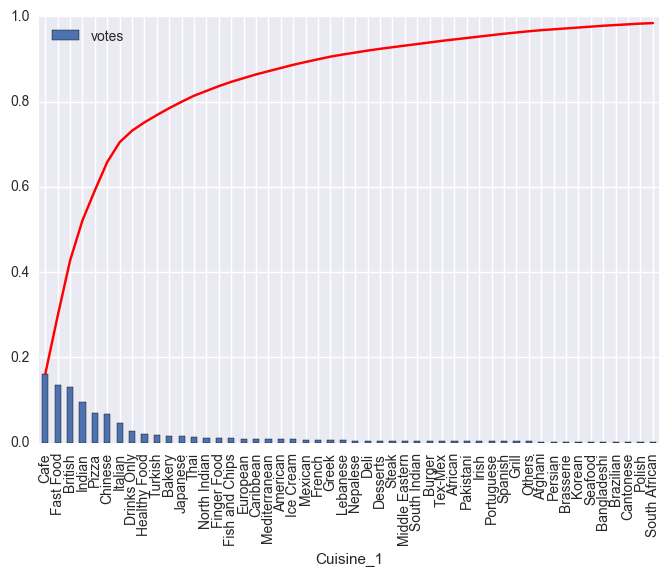

In [7]:
#How is the distribution of cuisine_1?
pivot3=pd.pivot_table(df_zomato,index=["Cuisine_1"],values=["votes"],aggfunc=np.count_nonzero).sort_values(by="votes",ascending=False)
pivot4=pivot3/sum(pivot3.values)
pivot4[:50].plot(kind="bar")
plt.plot(np.cumsum(pivot4[:50].values),c="r")
plt.show()

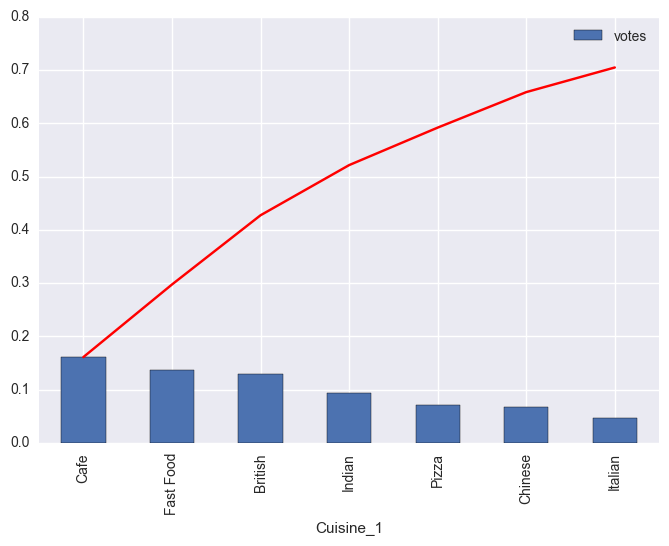

In [8]:
# Looking at cuisine type representing 70% of the restaurant.
pivot4[:7].plot(kind="bar")
plt.plot(np.cumsum(pivot4[:7].values),c="r")
plt.show()

7 types of cuisine represents 70% of the restaurants in London.
We'll try to join other cuisine in group such as it reflects the cuisine of their region (Middle east, Asian, East Europe,..)

In [9]:
# cuisine are grouped by "taste"/ concept.

dic_cuisine={"Meat": ["Rotisserie","Steak","Argentinian","BBQ","Brazilian","Brazilian food","Grill","European","Kosher","South American"],\
     "Chinese":["Chinese","Cantonese","Dim Sum","Sichuan"],\
     "Asian":["Malaysian","Japanese","Sushi","Thai","Pan Asian","Vietnamese","Korean","Indonesian","Asian","Filipino","Noodles","Indo-Chinese Fusion","Fusion"],\
     "Pizza":["Pizza"],\
     "Kebab":["Kebab"],\
     "Mediterranean":["Latin American","International","Mediterranean","Portuguese","Cypriot","Spanish","Greek","Peruvian","Seafood","Tapas"],\
     "African":["West African","South African","African",'Nigerian',"Moroccan","Egyptian","Ethiopian","Ghanaian","Mauritian"],\
     "Italian":["Italian","Pasta","Authentic Pizza"],\
     "French":["French","Crepes","Brasserie","Contemporary"],\
     "Middle Eastern":["Turkish","Arabian","Middle Eastern","Afghani","Syrian","Lebanese","Iraqi","Persian","Pakistani","Iranian","Afghan","Azerbaijan","Arabic"],\
     "Carribean":['Caribbean',"Jamaican"],\
     "Indian": ["Indian","","North Indian","Biryani","Nepalese","Bangladeshi","Sri Lankan","Sri-lankan","South Indian","Curry","Punjabi","Street Food"],\
     "British":["Fish & Chips","British","English","Continental","Irish","Fish and Chips"],\
     "Eastern Europe":["Polish","Russian","Hungarian","Swedish","Ukrainian","Romanian","Lithuanian","Georgian","Eastern European"],\
     "Healthy":["Healthy Food","Healthy","Vegan","Vegetarian","Gluten Free","Deli"],\
     "cafe":["Finger Food","Milkshakes","Bakery","Breakfast","Sandwiches","Juices","Beverages","Desserts","Cafe","Panini\'s","Cakes","Bubble Tea","Ice Cream","Smoothies","Drinks Only","Salads"],\
     "Northern American": ["Chicken","Burger","Tex-Mex","Fast Food","Peri Peri","American","Burgers","Mexican","Gourmet","Bagels","Subways"]}

In [10]:
# The function below will enable the mapping
def group_resto(row):
    position=-1
    word=""
    for i in range(len(dic_cuisine.values())):
        if row in dic_cuisine.values()[i]:
            position=i
    if position ==-1:
        word=np.nan
    else:
        word=dic_cuisine.keys()[position]
    
    return word
                
df_zomato["group_cuisine"]=df_zomato["Cuisine_1"].apply(group_resto)


In [11]:
df_zomato.loc[df_zomato.group_cuisine.isnull(),:]

,id,name,cuisines,price_range,average_cost_for_two,aggregate_rating,votes,city,locality,zipcode,latitude,longitude,Cuisine_1,Cuisine_2,Cuisine_3,group_cuisine
2338,16685971,Easy Cuisine,Others,1.0,0.0,0.0,0,London,Dartford,DA1 5,51.454302,0.205552,Others,,,NaN
2502,16686150,Warlingham Tandoori,Others,1.0,0.0,4.0,48,South East England,Tandridge,CR6 9,51.309673,-0.056540,Others,,,NaN
2504,16686066,Panahar,Others,1.0,0.0,3.3,12,South East England,Tandridge,CR2 9,51.320128,-0.065510,Others,,,NaN
2505,16685992,Golden Gate,Others,1.0,0.0,0.0,1,South East England,Tandridge,CR3 0,51.309232,-0.080102,Others,,,NaN
2506,16686029,La Brasa,Others,1.0,0.0,0.0,1,South East England,Tandridge,CR6 9,51.308495,-0.077184,Others,,,NaN
2507,16686021,Jumbos,Others,1.0,0.0,0.0,1,South East England,Tandridge,CR6 9,51.318063,-0.063514,Others,,,NaN
2508,16686113,Royal Tandoori,Others,1.0,0.0,3.3,11,South East England,Tandridge,CR3 0,51.309303,-0.079630,Others,,,NaN
2509,16686050,Mann's,Others,1.0,0.0,0.0,0,South East England,Tandridge,CR6 9,51.318063,-0.063514,Others,,,NaN
2510,16685959,Costa Del Sol,Others,1.0,0.0,2.9,5,South East England,Tandridge,CR3 0,51.309040,-0.079721,Others,,,NaN


In [12]:
# let's delete the row above as it is not in London area

df_zomato=df_zomato.loc[df_zomato.group_cuisine.notnull(),:]
df_zomato.reset_index(drop=True,inplace=True)
df_zomato.head()

,id,name,cuisines,price_range,average_cost_for_two,aggregate_rating,votes,city,locality,zipcode,latitude,longitude,Cuisine_1,Cuisine_2,Cuisine_3,group_cuisine
0,6111707,Barracuda,Drinks Only,2.0,25.0,2.6,7,London,Ealing,W5 2PJ,51.514176,-0.300338,Drinks Only,,,cafe
1,6102909,Starbucks,Cafe,1.0,15.0,3.1,4,London,Ealing,W5 5DA,51.511031,-0.305182,Cafe,,,cafe
2,6124523,The Ashbourne,"British, Pizza",3.0,40.0,0.0,0,London,Ealing,W5 3QU,51.529258,-0.291637,British,Pizza,,British
3,6125893,Ristorante Belvedere,Italian,3.0,50.0,0.0,1,London,Ealing,W5 1EE,51.530182,-0.292677,Italian,,,Italian
4,6125648,Royal Nawaab,"Indian, Curry",3.0,50.0,3.5,19,London,Greenford,UB6 8DW,51.533616,-0.318741,Indian,Curry,,Indian


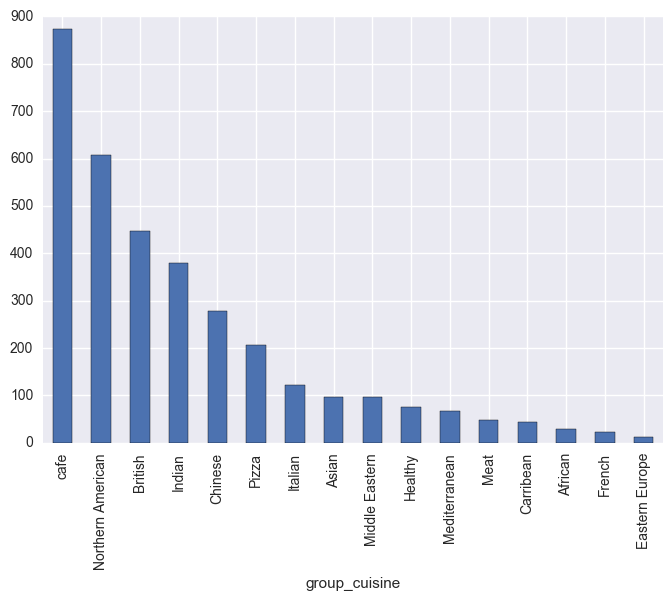

In [13]:
#let's have a look at the distribution
cuisine_qty=df_zomato.groupby(["group_cuisine"]).size().sort_values(ascending=False)
cuisine_qty.plot(kind="bar")
plt.show()

Cafe and Norther American take the lead, notably because it there is a lot of franchise such as Starbucks or Subway.
They are places where people stay for less than 20 min on average.
We can see that the top 6 includes a lot of places where people will not stay longer or take their meal away.

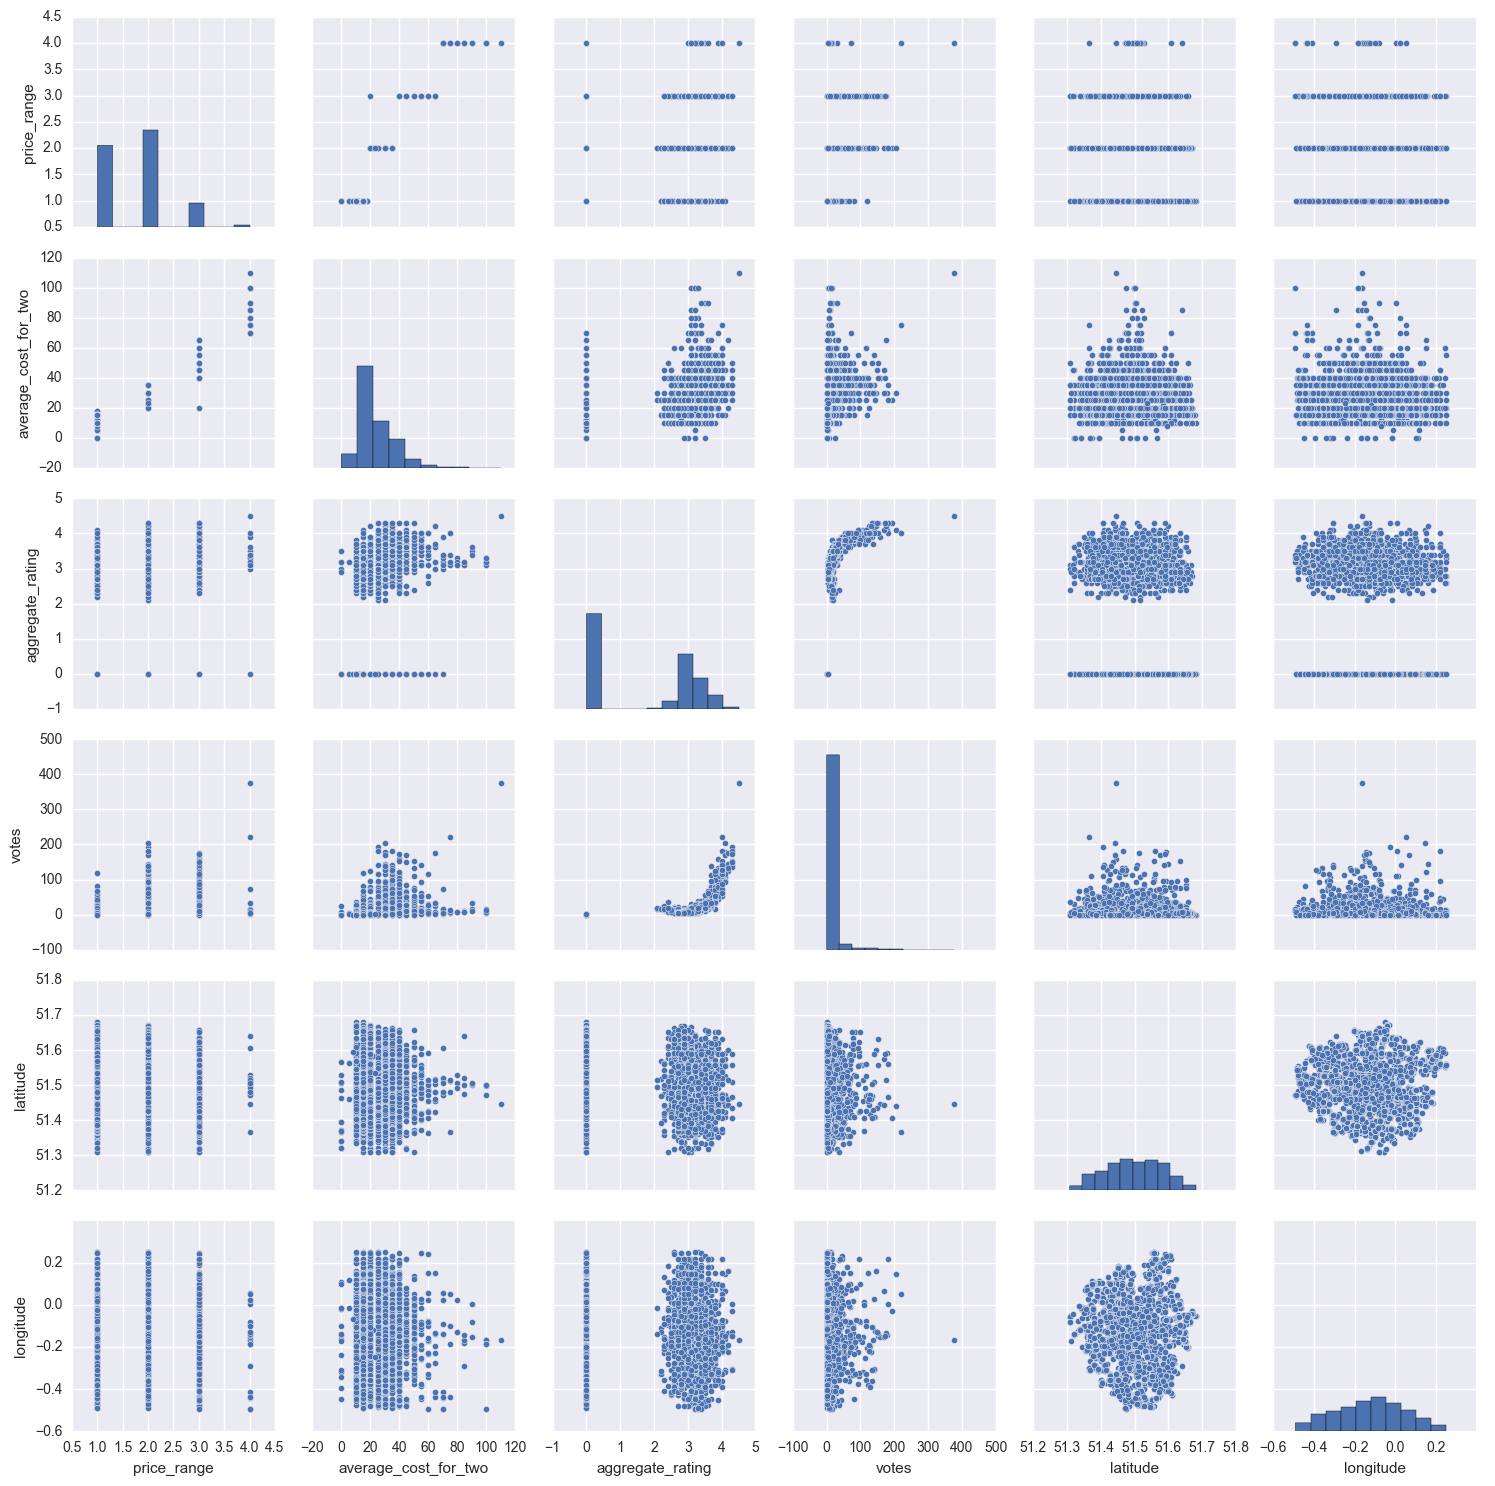

In [14]:
sns.pairplot(df_zomato,x_vars=[u'price_range',u'average_cost_for_two',u'aggregate_rating',u'votes',u'latitude',u'longitude']\
             ,y_vars=[u'price_range',u'average_cost_for_two',u'aggregate_rating',u'votes',u'latitude',u'longitude']\
             )
plt.show()

Some interesting facts above the graph above:
    - rating data seems to follow a normal distribution with  with range included between 2 and 4.5
    - the number of vote with the rating seems to be correlated, following a logarithmic distribution
    - Pricy restaurant seems to be in one same area
    - people does not tend to give reviews  for cheap and pricy restaurants
    - We face a high number of 0 votes
 
 
    

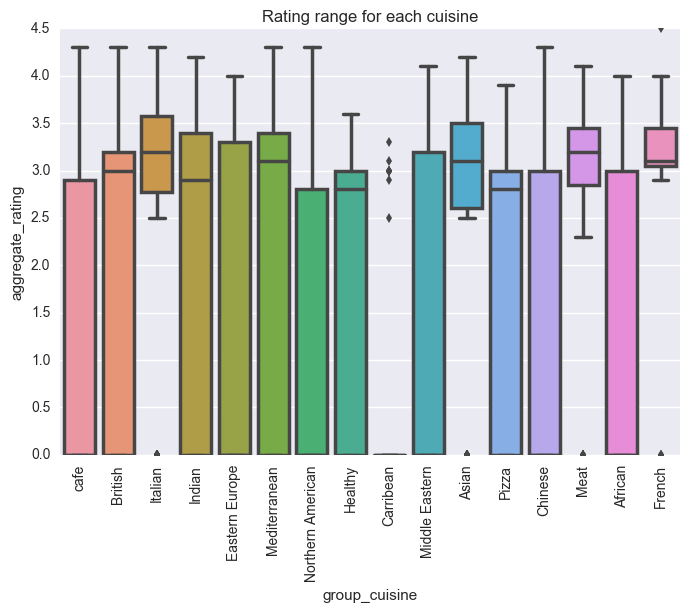

In [15]:

sns.boxplot(x="group_cuisine", y="aggregate_rating", data=df_zomato, linewidth=2.5)
plt.xticks(rotation=90)
plt.title("Rating range for each cuisine")
plt.show()

It seems that a lot of places has never been marked, it seems to be link to the lack of influence on Zomato compared to other rating websites (Tripadvisor) in UK.

In [16]:
# Comparing the 0 mark and number of votes
df_zomato.loc[(df_zomato["aggregate_rating"]==0),"votes"].value_counts()

0    1012
1     337
2     151
3      82
Name: votes, dtype: int64

A third of the present restaurant has never receive any votes. It seems to be restaurant opened in the past two year.

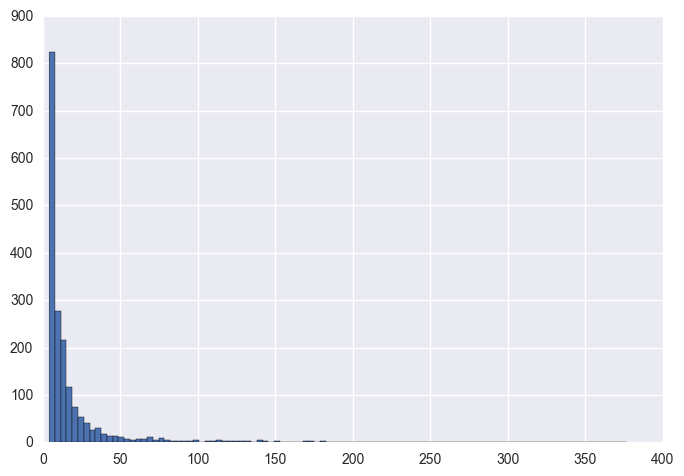

4     320
5     226
6     155
7     123
9      86
8      83
13     69
12     66
10     54
11     54
17     49
14     43
15     37
16     36
18     31
19     23
20     19
22     18
24     17
21     15
Name: votes, dtype: int64

In [17]:
# Exepting 0 votes, what is the distribution of the number of votes per restaurant
df_zomato.loc[(df_zomato["aggregate_rating"]!=0),"votes"].hist(bins=100)
plt.show()
df_zomato.loc[(df_zomato["aggregate_rating"]!=0),"votes"].value_counts().sort_values(ascending=False)[:20]

We do not have so many vote registered per restaurant on top of the high number of 0, it means that only the rating cannot be a qualifier attribute for a restaurant.

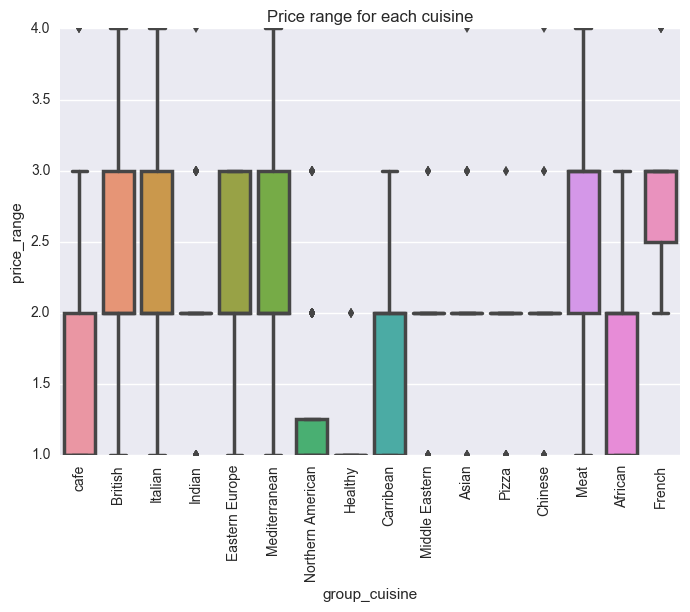

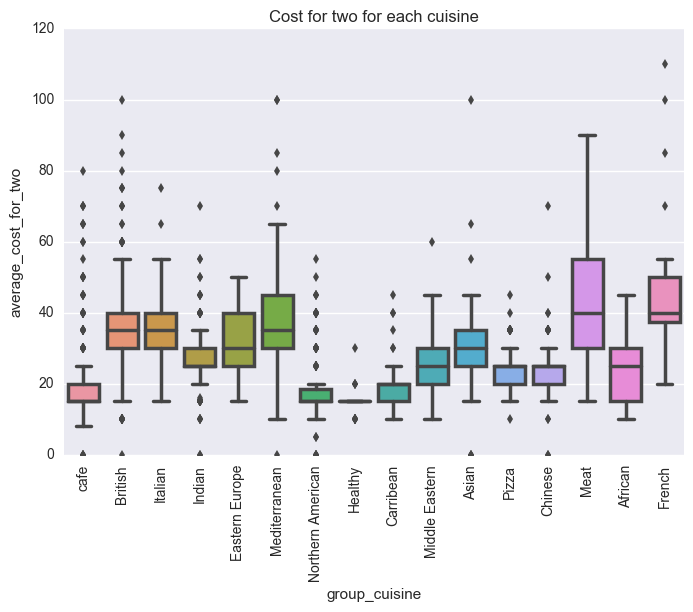

In [18]:
sns.boxplot(x="group_cuisine", y="price_range", data=df_zomato, linewidth=2.5)
plt.xticks(rotation=90)
plt.title("Price range for each cuisine")
plt.show()

sns.boxplot(x="group_cuisine", y="average_cost_for_two", data=df_zomato, linewidth=2.5)
plt.xticks(rotation=90)
plt.title("Cost for two for each cuisine")
plt.show()

Indeed, We can see ingredients will influence over the price of the meal.
Also as the price vary per cuisine, another factor enter into account, most probably the location of the restaurant which the study for the next paragraph.

___
# Linking restaurant postcode to its District and zone.

In [19]:
#Loading csv with postcode

postcode=pd.read_csv("L_postcode.csv")
pd.set_option("display.max_columns",200)

col_to_add=["Postcode","London zone","district_code","District"]

#merge information we need from postcode datafram to ou main df dataframe

df_zomato=pd.merge(df_zomato,postcode[col_to_add],how="left",left_on="zipcode",right_on="Postcode")

df_zomato.head()

/Users/dorian/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,cuisines,price_range,average_cost_for_two,aggregate_rating,votes,city,locality,zipcode,latitude,longitude,Cuisine_1,Cuisine_2,Cuisine_3,group_cuisine,Postcode,London zone,district_code,District
0,6111707,Barracuda,Drinks Only,2.0,25.0,2.6,7,London,Ealing,W5 2PJ,51.514176,-0.300338,Drinks Only,,,cafe,W5 2PJ,3.0,W5,Ealing
1,6102909,Starbucks,Cafe,1.0,15.0,3.1,4,London,Ealing,W5 5DA,51.511031,-0.305182,Cafe,,,cafe,W5 5DA,3.0,W5,Ealing
2,6124523,The Ashbourne,"British, Pizza",3.0,40.0,0.0,0,London,Ealing,W5 3QU,51.529258,-0.291637,British,Pizza,,British,W5 3QU,3.0,W5,Ealing
3,6125893,Ristorante Belvedere,Italian,3.0,50.0,0.0,1,London,Ealing,W5 1EE,51.530182,-0.292677,Italian,,,Italian,W5 1EE,3.0,W5,Ealing
4,6125648,Royal Nawaab,"Indian, Curry",3.0,50.0,3.5,19,London,Greenford,UB6 8DW,51.533616,-0.318741,Indian,Curry,,Indian,UB6 8DW,4.0,UB6,Ealing


In [20]:
# Verifying the value for district_code

df_zomato.loc[df_zomato.Postcode.isnull(),"city"].value_counts()

London                75
South East England     1
Name: city, dtype: int64

In [21]:
#Some match did not worked.
#I'll then match regarding the locality

districtcode_to_map=df_zomato.loc[df_zomato["Postcode"].isnull(),"locality"].unique()

for local in districtcode_to_map:
    for col in ["London zone","district_code","District"]:
        try:
            df_zomato.loc[((df_zomato["locality"]==local) & (df_zomato["Postcode"].isnull())),col]=df_zomato.loc[((df_zomato["locality"]==local) & (df_zomato["Postcode"].notnull())),col].unique()[0]
        except Exception:
            pass

In [22]:
print "Remaining locality with unknown zone:\n",df_zomato.loc[df_zomato.District.isnull(),"locality"].unique().tolist()
df_zomato=df_zomato.loc[df_zomato.District.notnull(),:]
df_zomato.reset_index(inplace=True, drop=True)

#deleting unecessary columns

to_delete=["Postcode","Cuisine_1","Cuisine_2","Cuisine_3","cuisines"]
for x in to_delete:
    del df_zomato[x]

df_zomato.head()

Remaining locality with unknown zone:
[u'East Molesey', u'Epsom', u'Buckhurst Hill', u'Tandridge', u'Caterham', u'Borehamwood']


,id,name,price_range,average_cost_for_two,aggregate_rating,votes,city,locality,zipcode,latitude,longitude,group_cuisine,London zone,district_code,District
0,6111707,Barracuda,2.0,25.0,2.6,7,London,Ealing,W5 2PJ,51.514176,-0.300338,cafe,3.0,W5,Ealing
1,6102909,Starbucks,1.0,15.0,3.1,4,London,Ealing,W5 5DA,51.511031,-0.305182,cafe,3.0,W5,Ealing
2,6124523,The Ashbourne,3.0,40.0,0.0,0,London,Ealing,W5 3QU,51.529258,-0.291637,British,3.0,W5,Ealing
3,6125893,Ristorante Belvedere,3.0,50.0,0.0,1,London,Ealing,W5 1EE,51.530182,-0.292677,Italian,3.0,W5,Ealing
4,6125648,Royal Nawaab,3.0,50.0,3.5,19,London,Greenford,UB6 8DW,51.533616,-0.318741,Indian,4.0,UB6,Ealing


In [23]:
# Saving the file to work with tableau
df_zomato.to_csv("zomato_clean.csv")

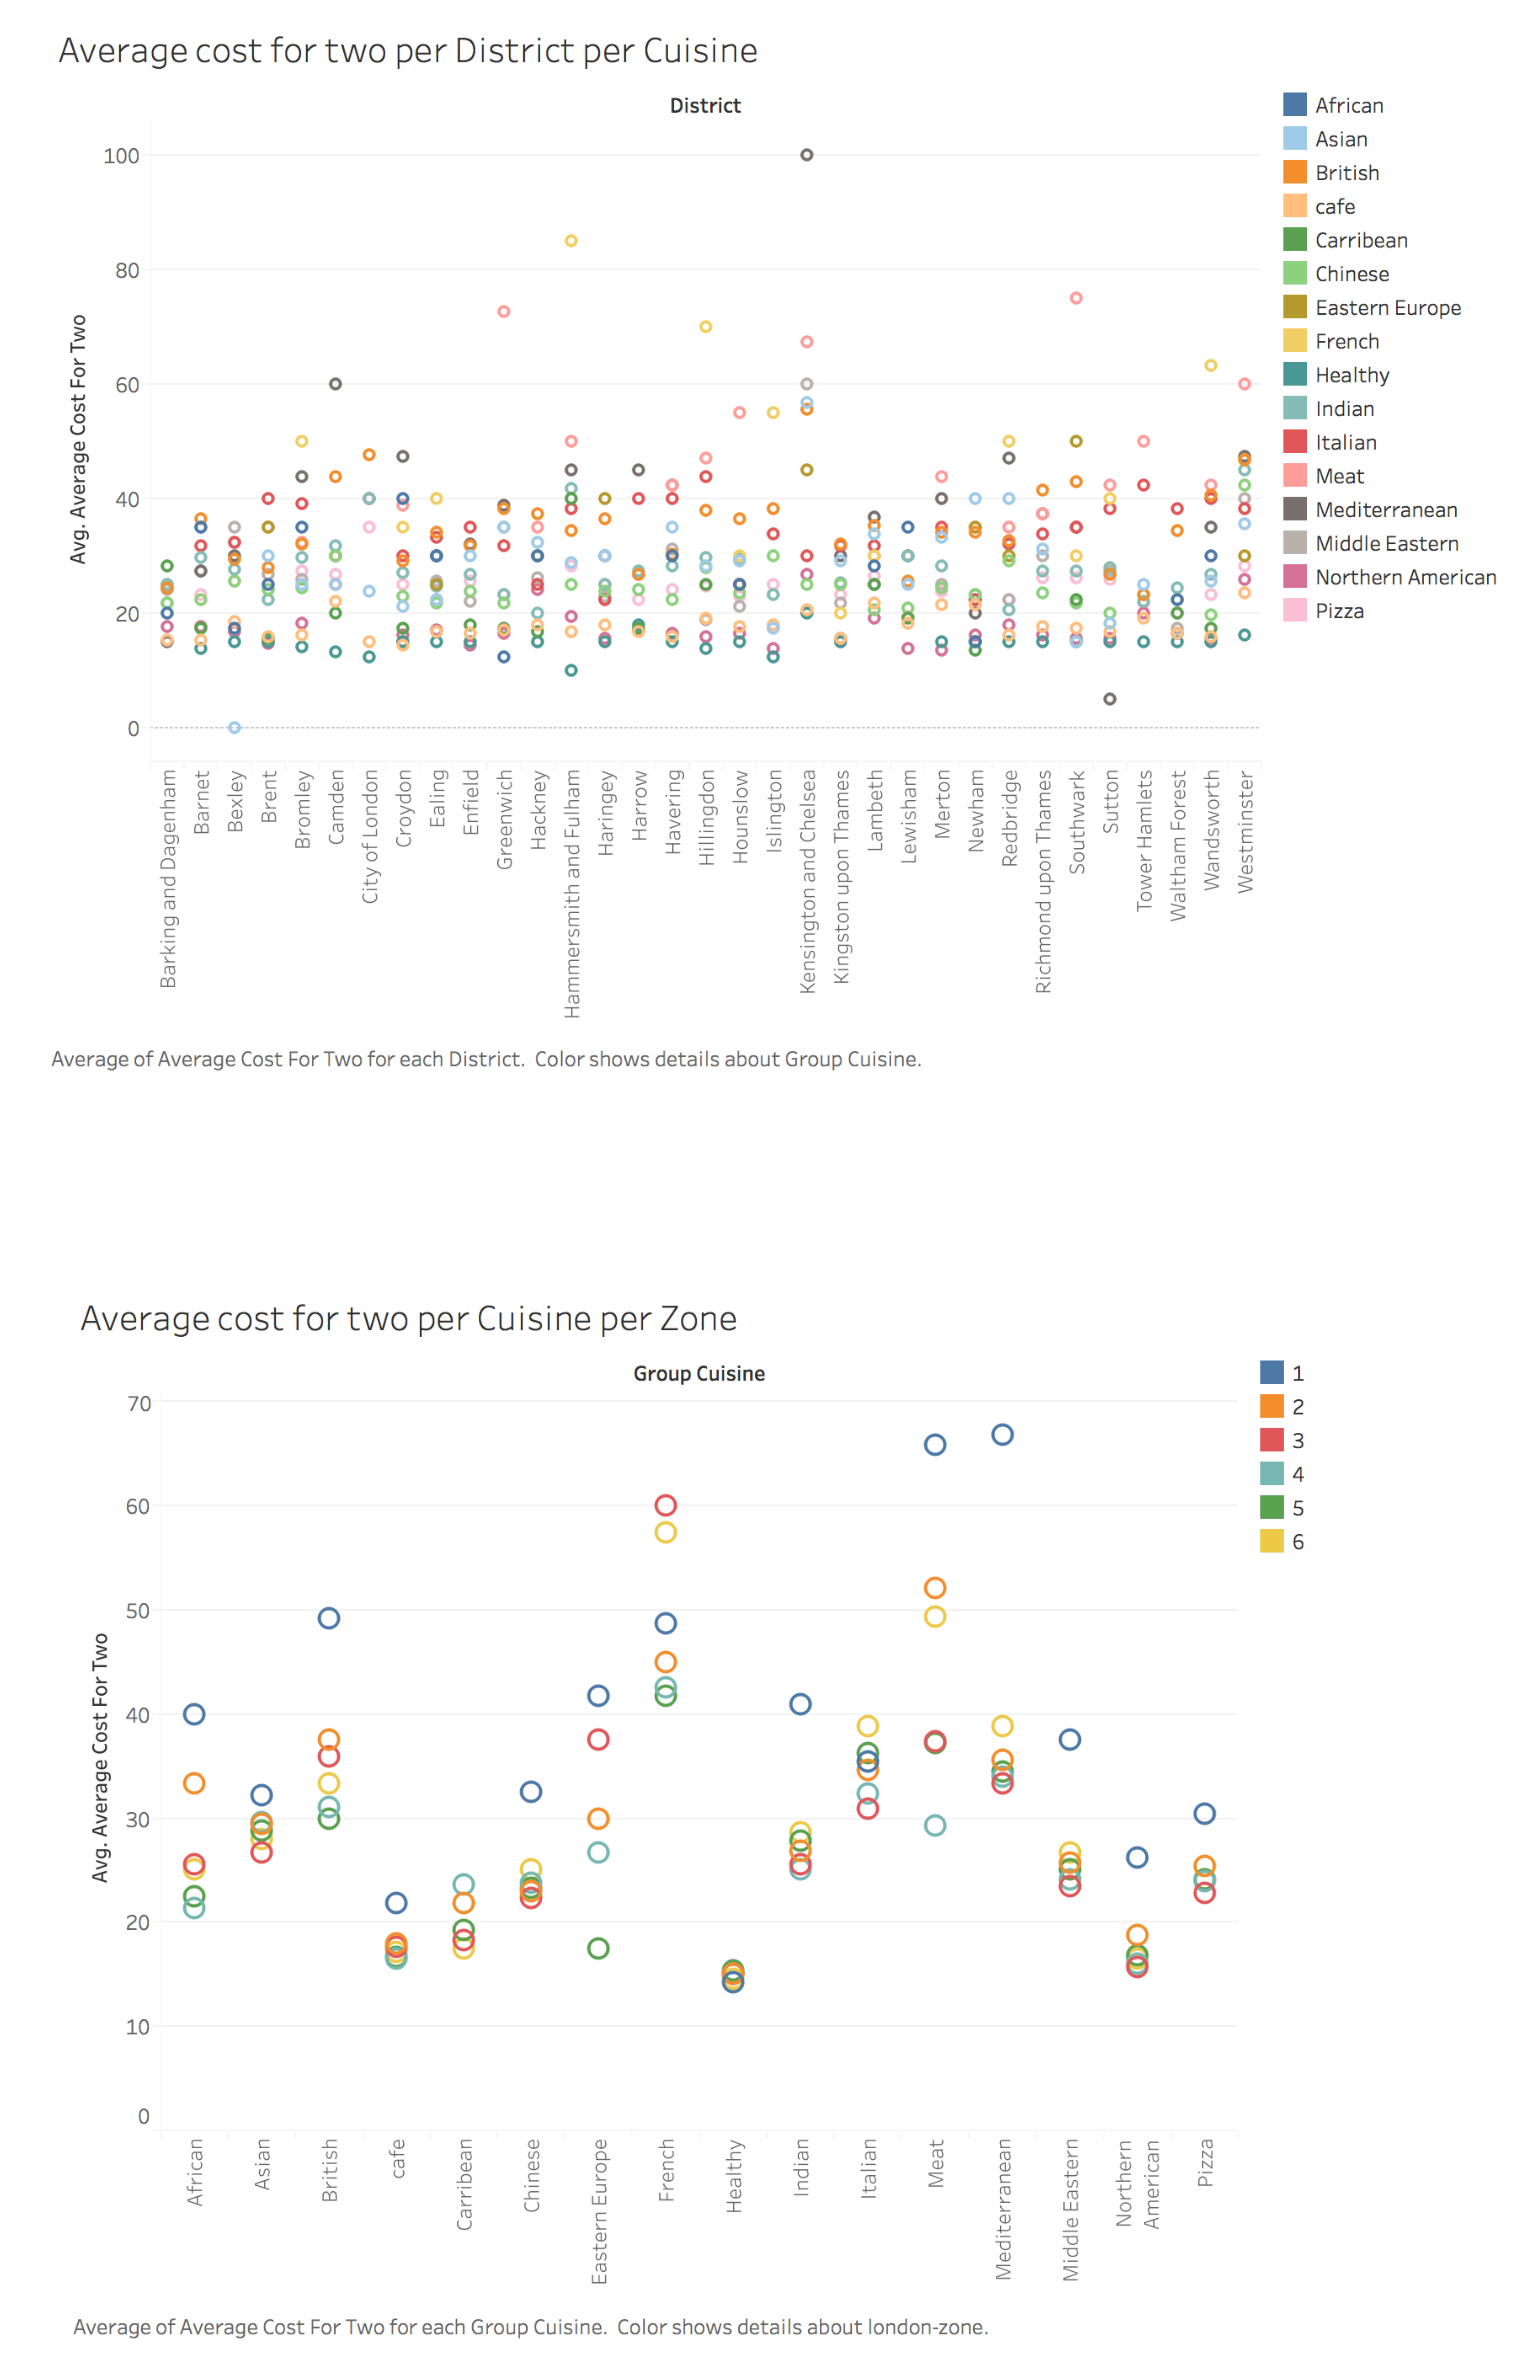

In [24]:
# print tableau plot minimum expenses average per cuisine per area
img1=plt.imread("cuisine_per_area_zomato.png")
plt.figure(figsize=(70,30))

ax1=plt.subplot(211)
ax1.axis("off")
ax1.imshow(img1)


img2=plt.imread("cuisine_per_zone_zomato.png")
ax2=plt.subplot(212)
ax2.axis("off")
ax2.imshow(img2)

plt.show()

For most cuisine, the price classification respects the london zone number.
However the difference can be quit significant as well as very close. For this last case, it means those restaurants expects much more customers to fill the gap of the operating cost.
We also have some are with 0 cost, probably because the restaurant is not active anymore


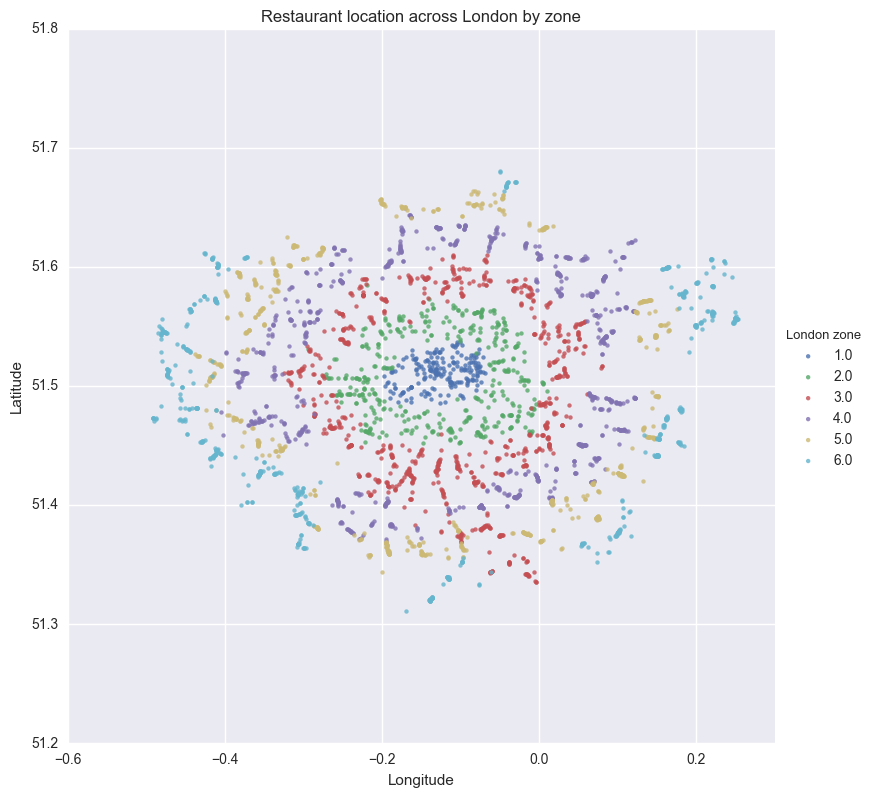

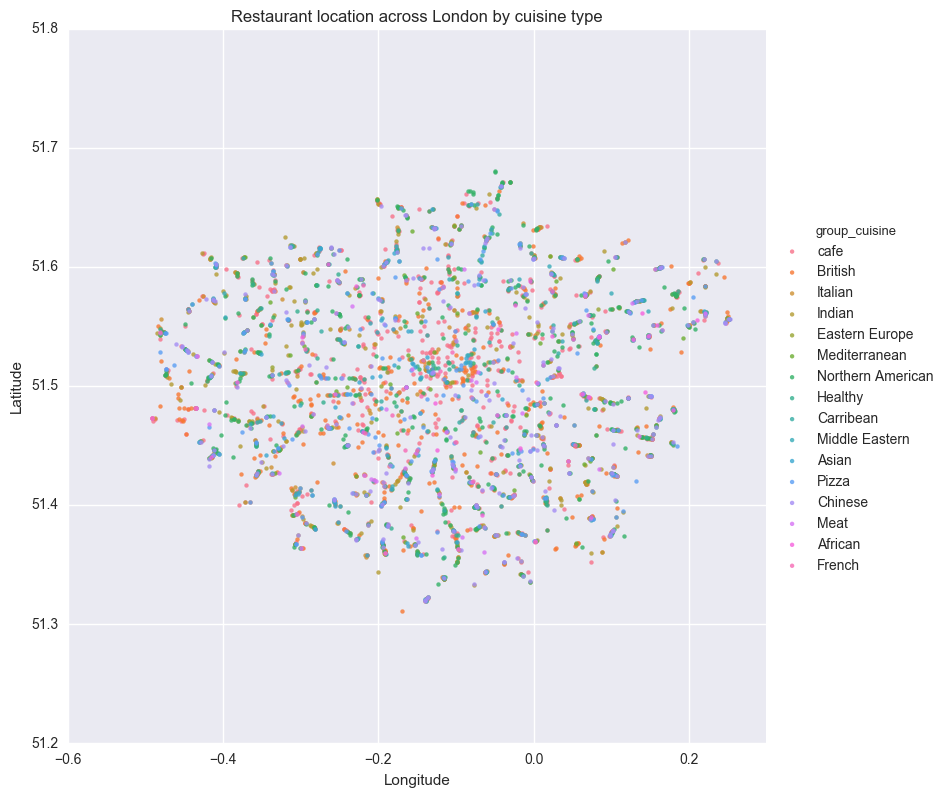

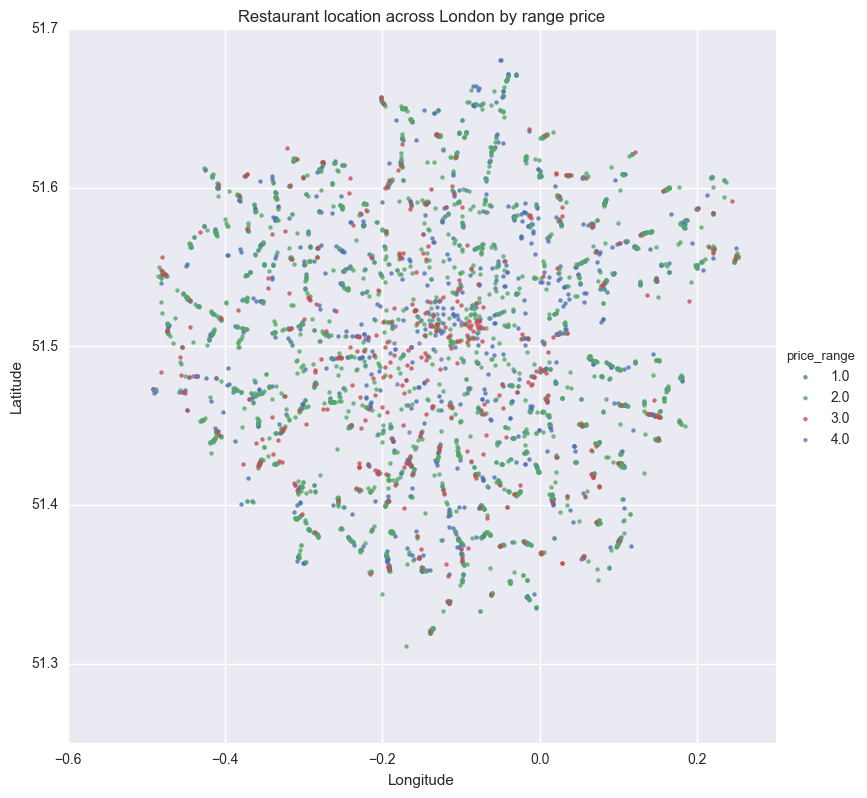

In [25]:
# Map of restaurant location in london by type of cuisine.


sns.lmplot('longitude', 'latitude', data=df_zomato, size=8,fit_reg=False, hue="London zone",scatter_kws={"marker": "D", "s": 10})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Restaurant location across London by zone')
plt.show()


sns.lmplot('longitude', 'latitude', data=df_zomato, size=8,fit_reg=False, hue="group_cuisine",scatter_kws={"marker": "D", "s": 10})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Restaurant location across London by cuisine type')
plt.show()


sns.lmplot('longitude', 'latitude', data=df_zomato, size=8,fit_reg=False, hue="price_range",scatter_kws={"marker": "D", "s": 10})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Restaurant location across London by range price')
plt.show()

We notice it is possible to encounter all type of foods across the different zones although only lower price range restaurants are peripheral.

___
# Calculating distance

The fast that a restaurant is surrounding by other restaurants or cafe as well as the distance to its main competitor as an impact over its attendance level.
That's why this part is focused on calulating the area cover by a restaurant outside competitor as well as counting the number of other food businesses near by.

In [26]:
#let's create a distrance grouping all the distance between each restaurant.
col_distance=["id","group_cuisine","latitude","longitude"]

X=df_zomato.loc[:,col_distance]

# The below function calculates the distance between any points on the Earth's surface 
# specified by their longitude and latitude in degrees.


from math import radians, cos, sin, asin, sqrt
def haversine(lonlat1, lonlat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1 = lonlat1
    lat2, lon2 = lonlat2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2.)**2 + cos(lat1) * cos(lat2) * sin(dlon/2.)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers.
    return c * r

In [27]:
# calculating the distance matrix
from scipy.spatial.distance import pdist, squareform
my_metric = pdist(X.ix[:,['latitude','longitude']], (lambda u,v: haversine(u,v)))
distance_matrix = squareform(my_metric)

distance=pd.DataFrame(distance_matrix,columns=X["id"])

X=pd.concat([X,distance],axis=1)

X.head()


,id,group_cuisine,latitude,longitude,6111707,6102909,6124523,6125893,6125648,6125737,6117266,6108414,6109419,6109510,6115478,6124197,6124266,6124243,6124263,6124186,6121287,6119066,6124204,6124241,6103058,6102889,6103076,6125807,6103518,6100612,6120244,6103731,6102884,6103458,6102867,6100490,6100506,6103987,6100584,6100630,6102600,6103117,6105004,6121789,6121873,6121800,6121840,6122948,6122966,6122980,6120534,6121876,6121869,6121883,6121886,6128367,6128331,6128363,6128354,6128343,6126531,6110874,6120253,6108377,6123294,6100840,6126458,6107677,6108181,6107696,6107401,6101490,6100923,6108710,6109130,6108117,6111491,6108401,6120977,6121174,6119047,6107425,6111786,6117785,6124959,6112350,6112106,6101108,6102112,6110159,6111145,6110808,6111134,6111249,6110879,6111998,6110062,6125239,6125240,6111212,...,6127915,6127925,6127933,6127970,6127931,6127914,6128047,6127911,6127928,6117901,6116225,6127684,6127680,6127683,6127685,6127682,6120754,6120662,6120777,6102449,6102828,6106364,6121972,6118787,6118807,6114668,6112126,6115044,6124876,6108508,6108608,6113759,6111968,6111809,6109032,6111955,6100940,6101000,6128040,6128001,6121230,6127827,6124626,6124612,6105944,6108842,6108849,6102651,6113761,6114292,6121564,6121620,6121619,6114807,6112056,6111816,6111438,6109347,6107682,6100272,6111878,6104070,6105409,6121569,6111708,6111881,6111888,6112204,6113174,6115237,6100343,6124956,6126316,6119325,17848855,17848285,6115961,6113564,6110961,6121553,6120350,6102897,6102471,17848852,6127979,6124746,6122651,6122692,6127132,6121173,6120554,6120560,6101478,6127958,6128042,6108822,18199627,6114842,6115491,6115804
0,6111707,cafe,51.514176,-0.300338,0.000000,0.484420,1.781818,1.857035,2.508719,1.300798,1.630305,0.324361,0.221868,0.163449,2.536521,1.124278,1.959203,1.779935,1.402001,1.221876,0.440310,0.206946,1.111625,1.355284,14.779149,14.676695,14.982222,13.261890,14.871315,14.178166,14.995286,13.875803,15.580563,14.359181,15.320765,15.429609,15.025572,14.283276,15.116724,14.768625,15.241234,13.227576,15.870574,29.759440,29.617981,29.760901,29.542537,28.999375,28.977757,28.896673,30.333318,29.569038,29.761053,29.761132,29.761053,30.445726,30.602765,31.427497,31.323651,31.128002,28.999488,29.867435,16.682644,15.175491,18.228417,17.095240,15.095069,16.890607,15.042294,17.857890,17.187477,16.521203,15.056041,15.020548,15.067268,15.077783,16.942160,15.165595,15.627504,15.353423,16.889796,25.415836,23.380594,25.877887,23.573332,25.830730,25.415015,25.655729,23.961430,25.867743,25.817700,23.364572,25.292550,25.826421,25.551344,25.563090,24.982973,25.424993,25.544751,25.303791,...,10.203230,10.673674,10.457607,10.657111,10.585783,10.595662,10.592637,10.609414,10.424903,8.496338,8.949902,16.606953,16.485459,16.599496,16.521639,16.459460,16.467163,16.409103,16.404842,16.516084,16.498320,5.267105,13.205606,13.580080,13.082006,13.653450,13.915099,5.640487,16.411587,16.405186,16.342176,12.695923,9.624218,9.698041,9.572614,9.729115,12.697014,9.567003,10.680815,11.671949,14.577467,11.527071,11.295255,11.295286,22.351097,23.057538,22.992705,21.958460,22.400757,23.234563,23.000038,23.004158,22.568563,23.234563,19.107815,19.092358,13.192639,9.901818,9.986768,9.712825,8.833429,9.720960,9.722197,17.262460,4.081244,3.749066,3.912365,4.060406,16.391576,24.973047,21.801651,22.644495,21.956576,29.514838,31.694000,31.702643,10.351146,10.023825,26.231784,26.408020,4.736376,13.555420,13.526032,33.269611,10.626958,7.444300,10.192731,9.675327,19.562825,20.068886,20.112120,20.087473,9.377252,8.321864,11.331337,19.453137,19.200096,16.870284,4.668518,4.543261
1,6102909,cafe,51.511031,-0.305182,0.484420,0.000000,2.232939,2.298550,2.680830,0.921474,1.792145,0.766980,0.329876,0.447287,2.223638,0.746753,1.571987,1.400845,1.027210,0.840498,0.192591,0.289773,0.740049,0.985343,15.116622,15.009311,15.351076,13.615383,15.240308,14.517383,15.349896,14.213463,15.913831,14.723218,15.646010,15.780806,15.342151,14.624069,15.465826,15.123746,15.606239,13.567840,16.234555,30.154079,30.013735,30.155495

Now I have the distance between each point, the idea is firstly to get the cluster of restaurants and notably count the number of restaurant nearby.
To that extent, I assume that people can walk up to 10 min to go to/find a restaurant/cafe. This represents more or less 600 meters. Imagining a pedestrian can walk randomly across an area, I will count how many restaurant area in a radius of 200 meters from each restaurant.

Secondly, I'll calculate the area cover by each restaurant before one of its competitor. I am reducing the calculation to the area cover by a disc of a radius "distance minimum to competitor/2" although the problem is mathematically  more complex than that.





In [28]:
# number of restaurant nearby.
n=X.shape[1]
number_in_cluster=[]

for i in range(4,n):
    count=(X.iloc[:,i]<=0.2).sum()
    number_in_cluster.append(count-1) 

X["restaurant_nearby"]=number_in_cluster
    

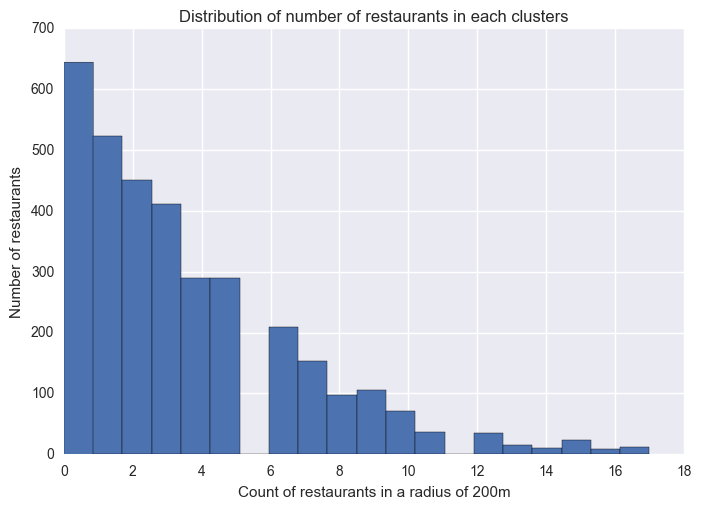

In [29]:
X["restaurant_nearby"].hist(bins=20)
plt.xlabel("Count of restaurants in a radius of 200m")
plt.ylabel("Number of restaurants")
plt.title("Distribution of number of restaurants in each clusters")
plt.show()

In [30]:
from math import pi

area_cover=[]

for i in range(4,n):
    min_dist=np.min(X.loc[(X[X.columns.tolist()[i]]!=0)&(X["group_cuisine"]==X.iloc[i-4,1]),X.columns.tolist()[i]]) 
    # I withdrew the diagonale and restaurants of diferent cuisine type.
    area_cover.append(pi*(min_dist/2)**2) #in km^2

X["area_cover"]=area_cover

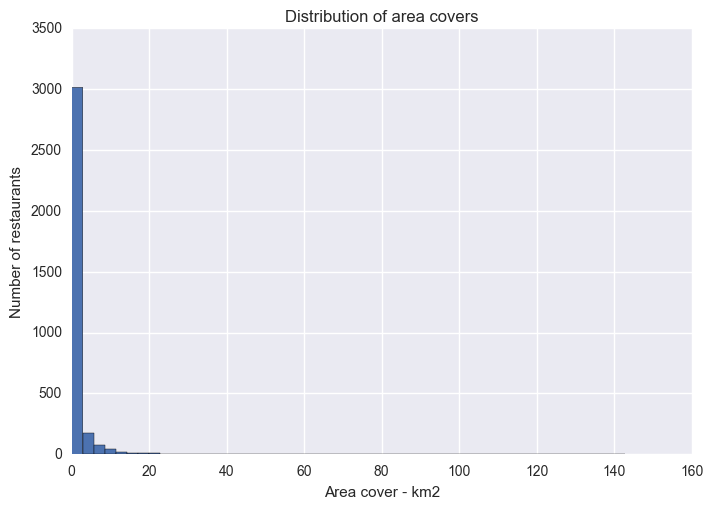

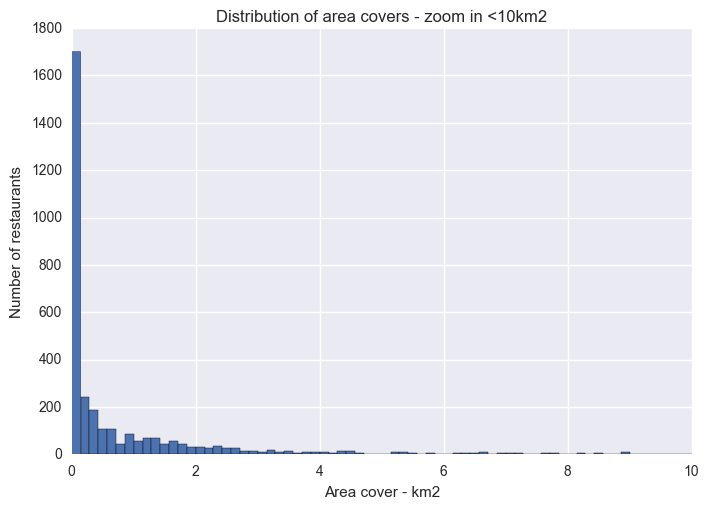

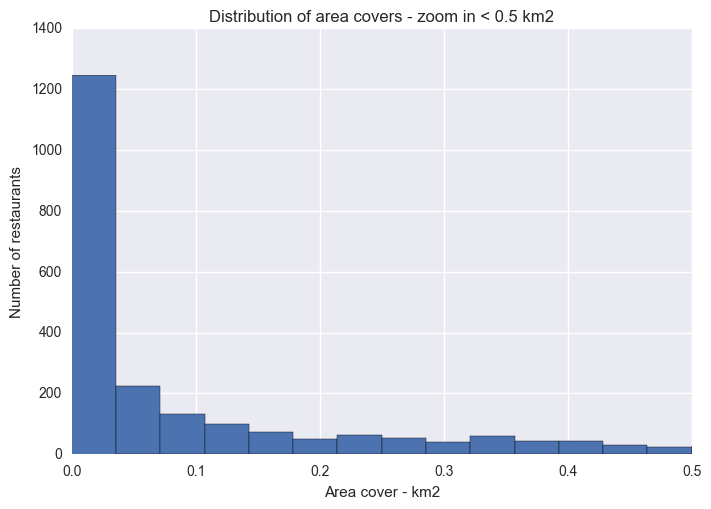

In [31]:
X["area_cover"].hist(bins=50)
plt.xlabel("Area cover - km2")
plt.ylabel("Number of restaurants")
plt.title("Distribution of area covers")
plt.show()

X["area_cover"].hist(bins=1000)
plt.xlabel("Area cover - km2")
plt.xlim((0,10))
plt.ylabel("Number of restaurants")
plt.title("Distribution of area covers - zoom in <10km2")
plt.show()

X["area_cover"].hist(bins=4000)
plt.xlabel("Area cover - km2")
plt.xlim((0,0.5))
plt.ylabel("Number of restaurants")
plt.title("Distribution of area covers - zoom in < 0.5 km2")
plt.show()

The area cover is under 100m^2 for more than a half of restaurants.

In [32]:
df_zomato["area_cover"]=X["area_cover"]
df_zomato["restaurant_nearby"]=X["restaurant_nearby"]

In [33]:
# We also can have a visualisation of the number of cluster via the Density base clustering method.
# It enables to gather in a same cluster restaurants which are below a maximum distance (eps) 
#between at least one point od the cluster

from sklearn.cluster import DBSCAN

#distance eps 0.2 km and mininum number of restaurant to build a cluster =5
db = DBSCAN(eps=0.2, min_samples=5, metric='precomputed')  # using "precomputed" as recommended by @Anony-Mousse
y_db = db.fit_predict(distance_matrix) 

df_zomato["cluster"]=y_db

print "Number of cluster: ", len(df_zomato["cluster"].unique())-1 
#retrievien value -1 which means the restaurant does not take part of a cluster
print "Five biggest cluster:\n", df_zomato["cluster"].value_counts().sort_values(ascending=False)[1:6]

Number of cluster:  186
Five biggest cluster:
25     25
88     20
114    20
6      20
107    20
Name: cluster, dtype: int64


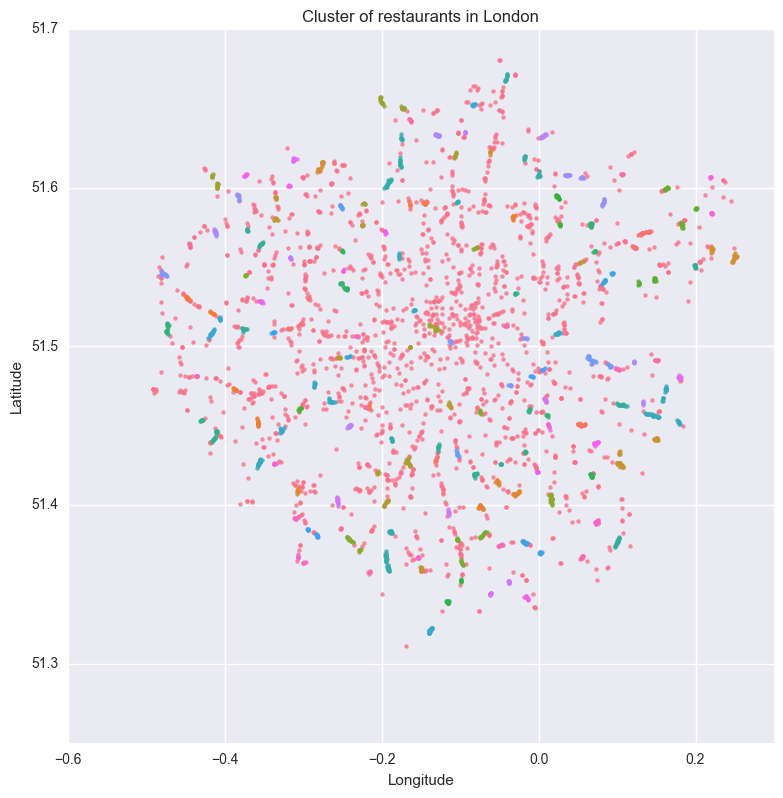

In [34]:
sns.lmplot('longitude', 'latitude', data=df_zomato, size=8,legend=False,fit_reg=False, hue="cluster",scatter_kws={"marker": "D", "s": 10})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cluster of restaurants in London')
plt.show()

In [37]:
df_zomato.to_csv("zomato_clean.csv")
df_zomato.to_sql("zomato_2",con=conn)

In [36]:
df_zomato.head()

,id,name,price_range,average_cost_for_two,aggregate_rating,votes,city,locality,zipcode,latitude,longitude,group_cuisine,London zone,district_code,District,area_cover,restaurant_nearby,cluster
0,6111707,Barracuda,2.0,25.0,2.6,7,London,Ealing,W5 2PJ,51.514176,-0.300338,cafe,3.0,W5,Ealing,0.016846,2,2
1,6102909,Starbucks,1.0,15.0,3.1,4,London,Ealing,W5 5DA,51.511031,-0.305182,cafe,3.0,W5,Ealing,0.033120,1,-1
2,6124523,The Ashbourne,3.0,40.0,0.0,0,London,Ealing,W5 3QU,51.529258,-0.291637,British,3.0,W5,Ealing,0.224057,2,0
3,6125893,Ristorante Belvedere,3.0,50.0,0.0,1,London,Ealing,W5 1EE,51.530182,-0.292677,Italian,3.0,W5,Ealing,5.336550,4,0
4,6125648,Royal Nawaab,3.0,50.0,3.5,19,London,Greenford,UB6 8DW,51.533616,-0.318741,Indian,4.0,UB6,Ealing,0.629461,0,-1


## Summary

The analysis shows us that even if Zomato gather a lot of restaurant in London ( more than 3000) most of them does not have reviews. This is due apparently to the fact that Zomato is not so mainstream anymore as it used to be and reviews are quite old to inexistent for restaurants that opened the past year. 
However, I will try to fit my model on Zomato data instead of just-eat to later on on, apply it to Tripadvisor data.
( when I will start to scrape it..)

Merging this dataset with Financial and Demographic information will permit to get an idea of the performance on each restaurant based the cuisine, price range ( 1-4), median house price and cost for 2.

__Next steps:__

- Getting more information about restaurant from Tripadvisor
- Analysis the location and cuisine of restaurant in function of all demographic and financial data.
- Categorise the well functioning of a restaurant
- Fit a model on my dataset 